<a href="https://colab.research.google.com/github/Asritha0606/GenerativeAI/blob/main/RAG_Using_query_tool.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -q llama-index llama-index-llms-gemini llama-index-embeddings-huggingface sentence-transformers transformers google-generativeai llama-index-llms-google-genai llama-index


# **Step 1** : Setting Up my API Key

In [3]:
import os
from google.colab import userdata
gemini_api_key = userdata.get('Gemini_api')
os.environ["gemini_api"] = gemini_api_key

# **Step 2** : Loading data and splitting it into chunks

In [11]:
# Working Environment Setup
import os
from google.colab import userdata

# If you are using jupyter notebook --> to make asynch play nice with jupyter notebook
# import nest_asyncio
# nest_asyncio.apply()

# Load Data/ Documents
from llama_index.core import SimpleDirectoryReader
documents = SimpleDirectoryReader(input_files=["/content/AYUSHMAN BHARAT.txt"]).load_data()

# Define Node Splitter
from llama_index.core.node_parser import SentenceSplitter
splitter = SentenceSplitter(chunk_size=1024)
nodes = splitter.get_nodes_from_documents(documents)

# Set up Gemini LLM and HuggingFace Sentence Transformer for embeddings
from llama_index.core import Settings
from llama_index.llms.google_genai import GoogleGenAI
#from llama_index.llms.gemini import Gemini
# Try the correct import path
from llama_index.embeddings.huggingface import HuggingFaceEmbedding

# If the above doesn't work, try this alternative import
# from llama_index.core.embeddings import HuggingFaceEmbedding

# Configure Settings with Gemini for LLM and Sentence Transformer for embeddings
Settings.llm = GoogleGenAI(api_key=gemini_api_key, model="models/gemini-1.5-flash")
Settings.embed_model = HuggingFaceEmbedding(model_name="sentence-transformers/all-MiniLM-L6-v2")

## **Step 3** : Define Summary index and Vector Index over the same Data

In [12]:
from llama_index.core import SummaryIndex, VectorStoreIndex

summary_index = SummaryIndex(nodes)
vector_index = VectorStoreIndex(nodes)


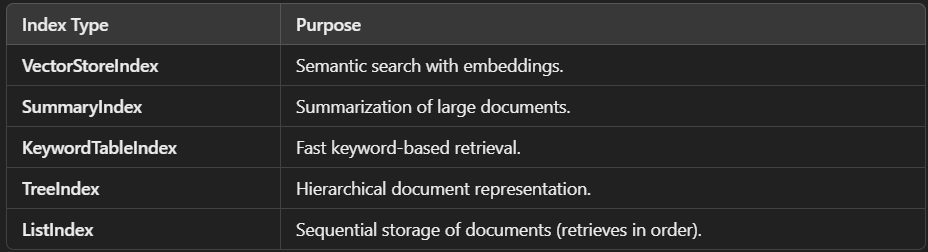

# **Step 4** : Creating Query Engines

There are different types of Query Engines in LlamaIndex

LlamaIndex provides different query engines based on retrieval and reasoning needs:

1. Vector-Based Query Engine (as_query_engine())

Retrieves top-k most relevant text chunks using vector similarity search.

2. Router Query Engine

Dynamically selects the best retrieval method (e.g., vector search, keyword search, tools).
Useful when combining multiple retrieval methods.

3. Transform Query Engine

Modifies queries before executing them (e.g., rephrasing, expanding queries).
Composable Query Engine

Combines multiple query engines (e.g., hybrid search with vector + keyword retrieval).


In [13]:
summary_query_engine = summary_index.as_query_engine(
    response_mode="tree_summarize",
    use_async=True,
)
vector_query_engine = vector_index.as_query_engine()

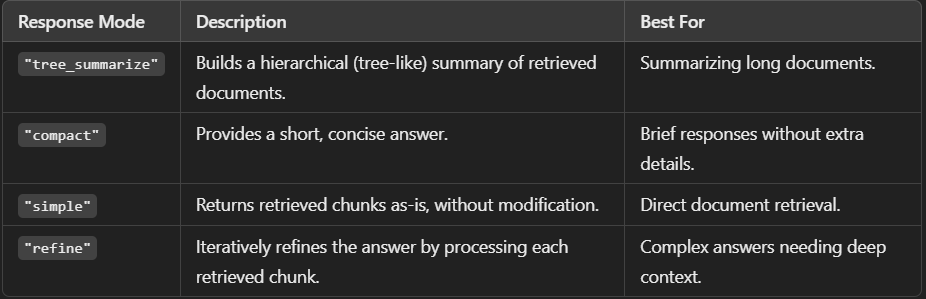

# **Step 5** : Converting the above Query Engine to Query tools

In [14]:
from llama_index.core.tools import QueryEngineTool

summary_tool = QueryEngineTool.from_defaults(
    query_engine=summary_query_engine,
    description=(
        "Useful for summarization questions related to dataset"
    ),
)

vector_tool = QueryEngineTool.from_defaults(
    query_engine=vector_query_engine,
    description=(
        "Useful for retrieving specific context from the dataset."
    ),
)

# **Step 6**: Asking Queries

In [15]:
from llama_index.core.query_engine.router_query_engine import RouterQueryEngine
from llama_index.core.selectors import LLMSingleSelector


query_engine = RouterQueryEngine(
    selector=LLMSingleSelector.from_defaults(),
    query_engine_tools=[
        summary_tool,
        vector_tool,
    ],
    verbose=True
)

# First query
response1 = query_engine.query("What is the summary of the document? \n")# Gist
print(response1.response.replace(". ", ".\n"))

# Second query
response2 = query_engine.query("What is the dominant age group that is affected with cyber crimes \n")
print(response2.response.replace(". ", ".\n"))

# Third Query
response3 = query_engine.query("Tell me about Bounds on Tail Probability \n")
print(response3.response.replace(". ", ".\n"))




Selecting query engine 0: The question explicitly asks for a summary of the document, which directly relates to summarization of a dataset (the document)..
The document details Ayushman Bharat, a program aiming for universal health coverage in India.
 It focuses on strengthening primary health care through Health and Wellness Centers (HWCs), transforming existing facilities to deliver comprehensive primary health care (CPHC).
 This initiative builds upon the National Health Mission (NHM), leveraging existing infrastructure and systems while requiring significant change management.
 Ayushman Bharat also includes the Pradhan Mantri Jan Arogya Yojana (PMJAY), offering financial protection for secondary and tertiary care.
 The success of PMJAY depends heavily on the effectiveness of CPHC through HWCs.
 Guidelines are provided to support the implementation of CPHC, emphasizing flexibility for states to adapt to their specific needs.
 These guidelines address systems requirements and change 

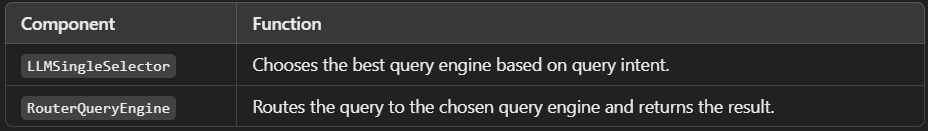